In [1]:
# import library and load dataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# load dataset
data_path = 'data/processed/data_for_outlier.csv' 
data = pd.read_csv(data_path)


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   object 
 1   Application mode                                4424 non-null   object 
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   object 
 4   Daytime/evening attendance                      4424 non-null   object 
 5   Previous qualification                          4424 non-null   object 
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nationality                                     4424 non-null   object 
 8   Mother's qualification                          4424 non-null   object 
 9   Father's qualification                   

In [3]:
# Check for missing values
data.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [4]:
# Handled Missing value
# Qualification - Unknown
missing_mother_qualification = (data["Mother's qualification"]=='Unknown').sum()
missing_father_qualification = (data["Father's qualification"]=='Unknown').sum()

# Occupation - (blank)
missing_mother_occupation = (data["Mother's occupation"]=='(blank)').sum()
missing_father_occupation = (data["Father's occupation"]=='(blank)').sum()
print("Missing Value")
print(f"Mother's Qualification: {missing_mother_qualification}")
print(f"Father's Qualification: {missing_father_qualification}")
print(f"Mother's Occupation: {missing_mother_occupation}")
print(f"Father's Occupation: {missing_father_occupation}")

Missing Value
Mother's Qualification: 130
Father's Qualification: 112
Mother's Occupation: 17
Father's Occupation: 19


In [5]:
# Count the number of students for each nationality
nationality_counts = data['Nationality'].value_counts().sort_index()

# Display the counts
print("Number of students per nationality:")
print(nationality_counts)

# print International students count
print("International", data['International'].value_counts())

Number of students per nationality:
Nationality
Angolan                     2
Brazilian                  38
Cape Verdean               13
Colombian                   1
Cuban                       1
Dutch                       1
English                     1
German                      2
Guinean                     5
Italian                     3
Lithuanian                  1
Mexican                     2
Moldova (Republic of)       3
Mozambican                  2
Portuguese               4314
Romanian                    2
Russian                     2
Santomean                  14
Spanish                    13
Turkish                     1
Ukrainian                   3
Name: count, dtype: int64
International International
no     4314
yes     110
Name: count, dtype: int64


In [6]:
# Feature Extraction

# Change Nationality -> Speaks Portuguese

# List of Portuguese-speaking countries
portuguese_speaking_countries = ['Portuguese', 'Brazilian', 'Angolan', 'Cape Verdean', 'Guinean', 'Mozambican', 'Santomean']

# Create a new column 'Speaks_Portuguese'
data['Speaks_Portuguese'] = data['Nationality'].apply(lambda x: 'yes' if x in portuguese_speaking_countries else 'no')

# Drop 'Nacionality' column
data.drop(columns=['Nationality'], inplace=True)

# Count the number who don't speak portuguese
non_speaker = (data["Speaks_Portuguese"]=='no').sum()
print(non_speaker)

36


180 students didn't enroll


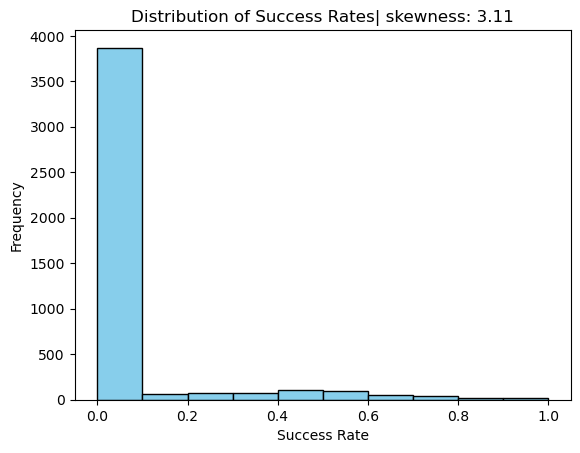

In [61]:
# Feature Extraction

# Combine enrolled and approved units across semesters
data['total_enrolled_unit'] = data['Curricular units 1st sem (enrolled)'] + data['Curricular units 2nd sem (enrolled)']
data['total_credited_unit'] = data['Curricular units 1st sem (credited)'] + data['Curricular units 2nd sem (credited)']

# Count the who didn't enroll
no_courses_count = data[data['total_enrolled_unit'] == 0].shape[0]
print(f"{no_courses_count} students didn't enroll")

# Success Rate
data['success_rate'] = data.apply(
    lambda row: row['total_credited_unit'] / row['total_enrolled_unit'] 
                if row['total_enrolled_unit'] > 0 else 0,
    axis=1
)

# Bar plot
plt.hist(data['success_rate'], bins=10, color='skyblue', edgecolor='k')
plt.title(f"Distribution of Success Rates| skewness: {round(data['success_rate'].skew(), 2)}")
plt.xlabel("Success Rate")
plt.ylabel("Frequency")
plt.show()

In [7]:
# Data Transformation

X = data.drop('Target', axis=1)
y = data['Target']

# Separate numerical and categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Convert object type to categorical
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Convert to ordinal categorical
application_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
application_dtype = CategoricalDtype(categories=application_order, ordered=True)
X['Application order'] = X['Application order'].astype(application_dtype)

categorical_cols = X.select_dtypes(include=['category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# List of columns to drop
columns_to_drop = [
    "Previous qualification (grade)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Unemployment rate",
    "Inflation rate",
    "GDP"
]

skewed_cols = numerical_cols.difference(columns_to_drop)

print(skewed_cols)

Index(['Admission grade', 'Age at enrollment',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)'],
      dtype='object')


In [8]:
# Transform skewed features
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X[skewed_cols] = pt.fit_transform(X[skewed_cols])

# Normalize all numerical features
# Initialize scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Standardize numerical columns
X[numerical_cols] = scaler_standard.fit_transform(X[numerical_cols])

# Normalize numerical columns
X[numerical_cols] = scaler_minmax.fit_transform(X[numerical_cols])

for col in skewed_cols:
    print(f'{col}')
    print(f'before: {round(data[col].skew(), 2)}, after: {round(X[col].skew(), 2)}')
    print()

Admission grade
before: 0.53, after: -0.0

Age at enrollment
before: 2.05, after: 0.48

Curricular units 1st sem (approved)
before: 0.77, after: -0.04

Curricular units 1st sem (credited)
before: 4.17, after: 2.2

Curricular units 1st sem (enrolled)
before: 1.62, after: 0.53

Curricular units 1st sem (evaluations)
before: 0.98, after: 0.21

Curricular units 1st sem (grade)
before: -1.57, after: -1.15

Curricular units 1st sem (without evaluations)
before: 8.21, after: 3.48

Curricular units 2nd sem (credited)
before: 4.63, after: 2.34

Curricular units 2nd sem (enrolled)
before: 0.79, after: 0.55

Curricular units 2nd sem (grade)
before: -1.31, after: -1.09

Curricular units 2nd sem (without evaluations)
before: 7.27, after: 3.57



In [9]:
# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_data = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_data.columns = encoder.get_feature_names_out(categorical_cols)

# Combine the data
X = X.drop(categorical_cols, axis=1)
X = pd.concat([X, encoded_data], axis=1)

In [10]:
# Feature information after transformation
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Columns: 243 entries, Previous qualification (grade) to Speaks_Portuguese_yes
dtypes: float64(243)
memory usage: 8.2 MB


In [11]:
# Target information
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4424 entries, 0 to 4423
Series name: Target
Non-Null Count  Dtype
--------------  -----
4424 non-null   int64
dtypes: int64(1)
memory usage: 34.7 KB


In [12]:
# Target distribution
value_percentages = y.value_counts(normalize=True) * 100
print(value_percentages)

Target
1    67.879747
0    32.120253
Name: proportion, dtype: float64


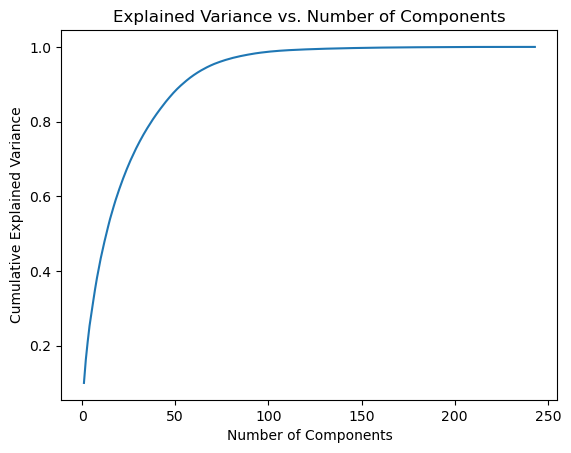

Selected number of components: 69
Cumulative explained variance for first 69 components: 0.95


In [13]:
# Step 1: Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Step 2: Plot explained variance to determine the number of components to keep
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Step 3: Choose k components that explain, e.g., 95% variance
k = 0
for i, cumulative in enumerate(cumulative_variance):
    if cumulative >= 0.95:  # 95% explained variance threshold
        k = i + 1
        break

# Step 4: Apply PCA with k components
pca = PCA(n_components=k)
X_reduced = pca.fit_transform(X)

print(f"Selected number of components: {k}")
print(f"Cumulative explained variance for first {k} components: {cumulative_variance[k-1]:.2f}")


In [14]:
print(f'Size before PCA: {X.shape}')
print(f'Size after PCA: {X_reduced.shape}')

Size before PCA: (4424, 243)
Size after PCA: (4424, 69)
